In [29]:
import pandas as pd
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [30]:
def get_currency_rates(date=None):
    if date is None:
        date = datetime.now().strftime('%Y%m%d')
    else:
        date = date.strftime('%Y%m%d')

    url = f'https://bank.gov.ua/NBUStatService/v1/statdirectory/exchange?date={date}&json'
    response = requests.get(url)

    data = response.json()
    df = pd.DataFrame(data)
    df['date'] = datetime.strptime(date, '%Y%m%d').date()
    df['retrieval_time'] = datetime.now()
    return df

In [ ]:
def collect_weekly_data():
    dates = [datetime.now() - timedelta(days=i) for i in range(7)]
    dfs = []

    for date in dates:
        daily_data = get_currency_rates(date)
        if daily_data is not None:
            dfs.append(daily_data)
        else:
            print(f"Не вдалося отримати дані для {date.date()}")

    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        return None



2025-05-04 10:47:57.693251


In [ ]:
def transform_data(df):
    currencies = df[df['cc'] != 'UAH']['cc'].unique()
    selected_currencies = pd.Series(currencies).sample(
        20, random_state=42).tolist()

    filtered_df = df[df['cc'].isin(selected_currencies)].copy()

    aggregated = filtered_df.groupby('cc').agg({
        'rate': ['mean', 'std'],
        'date': 'count'
    })
    aggregated.columns = ['mean_rate', 'std_deviation', 'days_count']

    filtered_df = filtered_df.sort_values(['cc', 'date'])
    filtered_df['prev_rate'] = filtered_df.groupby('cc')['rate'].shift(1)
    filtered_df['rate_change'] = (
        filtered_df['rate'] - filtered_df['prev_rate']) / filtered_df['prev_rate'] * 100

    mean_change = filtered_df.groupby(
        'cc')['rate_change'].mean().rename('mean_rate_change')

    result = pd.concat([aggregated, mean_change], axis=1)

    return filtered_df, result

In [33]:
def save_data(raw_data, aggregated_data, raw_filename='currency_rates_raw.csv', aggregated_filename='currency_rates_aggregated.csv'):
    """Збереження даних у CSV файли"""
    raw_data.to_csv(raw_filename, index=False)
    aggregated_data.to_csv(aggregated_filename)

In [34]:
def visualize_data(raw_data, aggregated_data):
    """Візуалізація даних про курси валют з конкретними валютами та значеннями"""
    plt.figure(figsize=(15, 12))

    selected_currencies = ['USD', 'EUR', 'CHF', 'CAD', 'PLN']
    currency_names = {
        'USD': 'Долар США',
        'EUR': 'Євро',
        'CHF': 'Швейцарський франк',
        'CAD': 'Канадський долар',
        'PLN': 'Польський злотий'
    }

    plt.subplot(2, 1, 1)
    for currency in selected_currencies:
        currency_data = raw_data[raw_data['cc'] == currency]
        if not currency_data.empty:
            plt.plot(currency_data['date'], currency_data['rate'],
                     label=f"{currency} ({currency_names.get(currency, '')})",
                     marker='o', linestyle='-', linewidth=2)

            for i, (date, rate) in enumerate(zip(currency_data['date'], currency_data['rate'])):
                    plt.annotate(f"{rate:.2f}",
                                (date, rate),
                                textcoords="offset points",
                                xytext=(0, 10),
                                ha='center',
                                fontsize=9)

    plt.title('Динаміка курсів основних валют за тиждень', fontsize=14, pad=20)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Курс до UAH', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(2, 1, 2)

    selected_data = aggregated_data[aggregated_data.index.isin(
        selected_currencies)]

    std_dev = selected_data['std_deviation'].values
    mean_rates = selected_data['mean_rate'].values

    bars = plt.bar(x=range(len(selected_data)), 
                   height=mean_rates,
                   yerr=std_dev,
                   capsize=10,
                   color=['#1f77b4', '#ff7f0e',
                          '#2ca02c', '#d62728', '#9467bd'],
                   tick_label=selected_data.index) 

    plt.xticks(range(len(selected_data)),
               [f"{code}\n({currency_names.get(code, '')})" for code in selected_data.index],
               fontsize=10)

    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.annotate(f"{mean_rates[i]:.2f} ± {std_dev[i]:.4f}",
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), 
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=10,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1))

    plt.title('Середній курс обраних валют з діапазонами коливань',
              fontsize=14, pad=20)
    plt.xlabel('Валюта', fontsize=12)
    plt.ylabel('Середній курс до UAH', fontsize=12)
    plt.tight_layout(pad=3.0)

    plt.show()

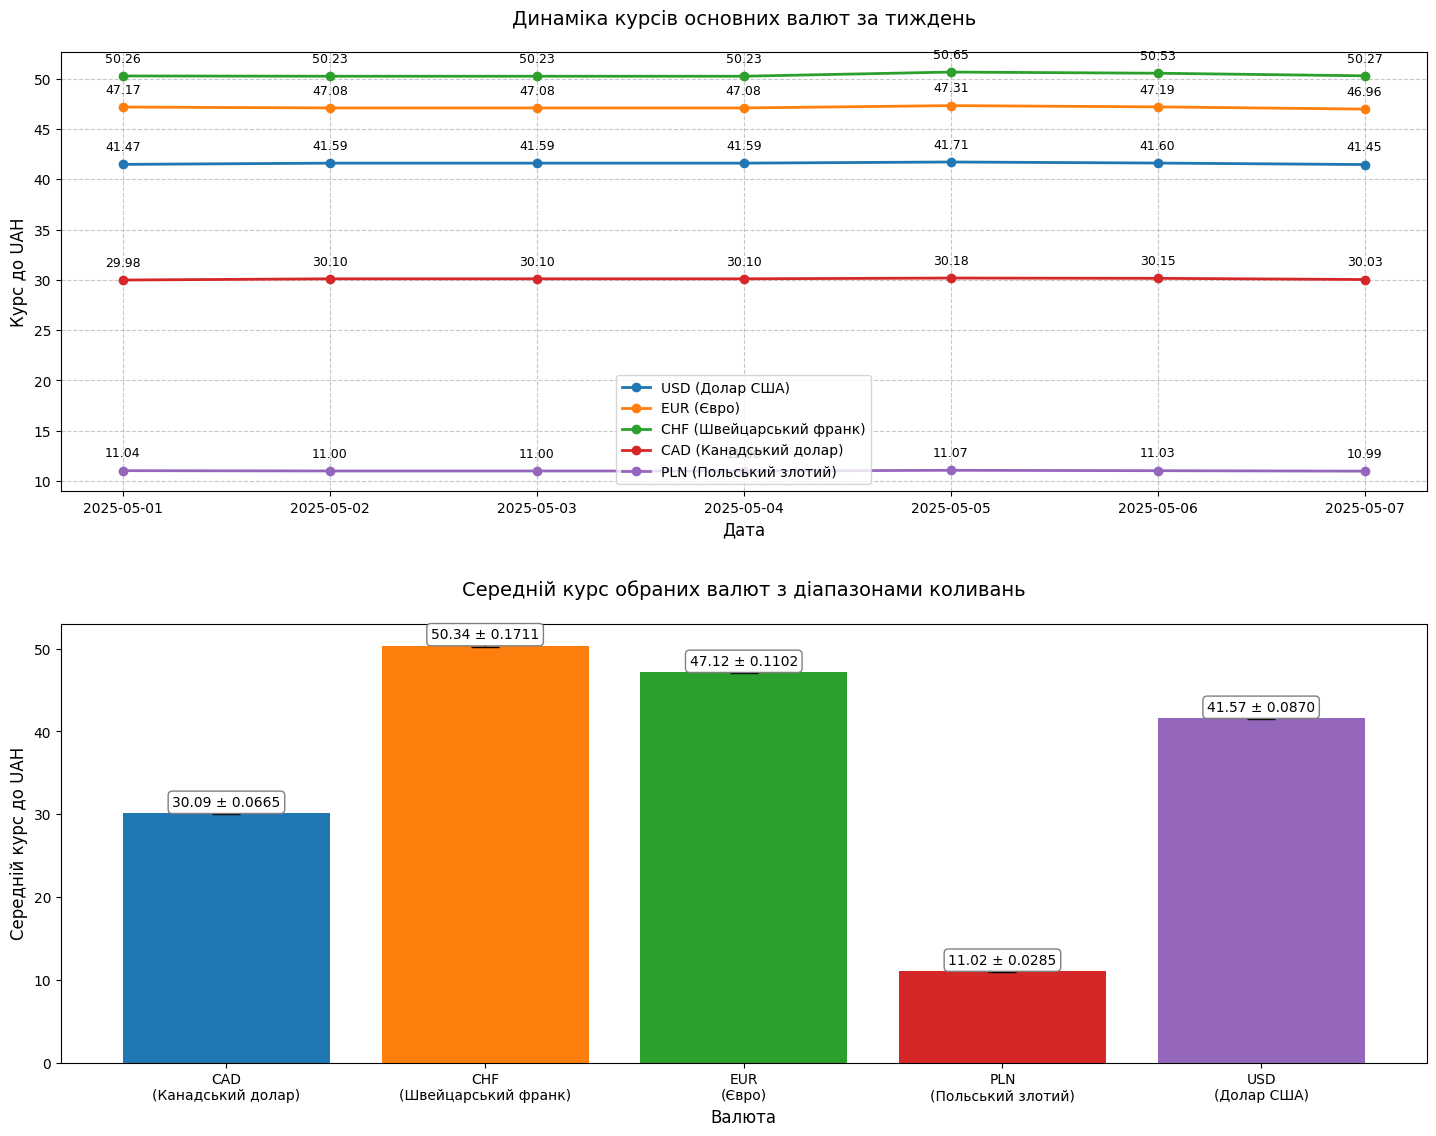

In [35]:
def main():

    raw_data = collect_weekly_data()

    raw_data, aggregated_data = transform_data(raw_data)

    save_data(raw_data, aggregated_data)

    visualize_data(raw_data, aggregated_data)


if __name__ == "__main__":
    main()